# Graphing Airtable Data

In [1]:
import sys
import os
from airtable import Airtable
import pandas as pd
import numpy as np

import plotly.offline as py
import plotly.graph_objs as go
import cufflinks as cf
from cufflinks import tools

## Introduction

Airtable is an awesome tool for centralizing data and running multiple different segments of your business. However, sometimes we can have so much tabular data that it is hard to really grasp week-to-week developments.

It is possible (on the pro plan) to build charts using Airtable’s code blocks. Another option is to export to excel. But to really supercharge your analytics, this work should be as automated as possible. So this guide will show how you can fetch Airtable data from a Jupyter Notebook, manipulate and visualize this data, all in Python.

This post is for you if:
- You are already using Airtable for some specific knowledge management — your sales CRM, for example — but are frustrated with the built-in data visualization features.
- If you think your team could benefit from a more automated process for tracking metrics that impact decision-making.


If you want to run this notebook, the install & setup instructions are kept in the Readme.md. By using a python wrapper for Airtable, and cufflinks, we can quickly query data and visualize key metrics.

## Fetching our data

For the purpose of this guide, we will work with one of Airtable’s sample templates — the [Sales Pipeline base](https://airtable.com/templates/sales-and-customers/expuCeCuZwIAc89uI/sales-pipeline). Let’s fetch the data:

In [2]:
base_key = 'appYpXIjwBDcLEzaz'
api_key = os.environ['AIRTABLE_API_KEY']


sales_table = Airtable(base_key,
                               table_name='Sales Deals',
                               api_key=api_key).get_all()

rep_table = Airtable(base_key,
                               table_name='Sales Reps',
                               api_key=api_key).get_all()

where ‘AIRTABLE_API_KEY’ is the global variable we have set in our bash profile (see Readme.md) and ‘BASE_ID’ is the ID for the specific base we are working with. Airtable’s REST API interface can be found here: https://airtable.com/api, where you can access a list of all your Airtable bases. Each Airtable base will provide its own API to create, read, update, and destroy records.

We have pulled in 2 different responses the correspond to the two tables inside our Sales Pipeline base.

## Converting the response to Pandas DataFrames

Now let's parse the JSON response returend from our queries defined in the previous step into pandas dataframes, which will make it much easier to manipulate and graph the data.

In [9]:
# Sales Data

sales_df = pd.DataFrame(sales_table)
sales_df = pd.merge(sales_df.drop('fields', axis=1), sales_df['fields'].apply(pd.Series)
                   , left_index=True, right_index=True)
sales_df['Rep'] = sales_df['Rep'].str[0]


# Sales Rep Data

rep_df = pd.DataFrame(rep_table)
rep_df = pd.merge(rep_df.drop('fields', axis=1), rep_df['fields'].apply(pd.Series)
                   , left_index=True, right_index=True)


# Merging the two dataframes to get Rep names on the sales table
sales_df = sales_df.merge(rep_df, left_on='Rep',right_on='id', how='inner').drop(['id_y','createdTime_y','All Sales Deals','Quota','Start Date',
                                                                                  'Closed Amount','% of Quota','Status','Rep'],axis=1)
sales_df.columns = sales_df.columns.str.replace("[_|x]", "")
sales_df = sales_df.rename(columns={"Namey": "Rep"})

Above we’ve assigned our responses to variables and read them into their respective DataFrames. The response from Airtable comes in the form of an ordered dictionary, which we’ve had to parse above.

## Visualising Our Data

Now it is time to start gaining insights from our data, but first up:

**Define your business questions**

What business questions do you want to answer? We’ve laid out some example questions for our sample sales pipeline data.

1. What is the value of our closed deals? Who has secured the most revenue?
2. What stages are other deals at in the pipeline? What is the weighted value of these deals?
3. What are our forecasted targets?
4. How are our sales reps doing? Are they hitting their quotas?

### 1. Closed deals by contract size and sales representative

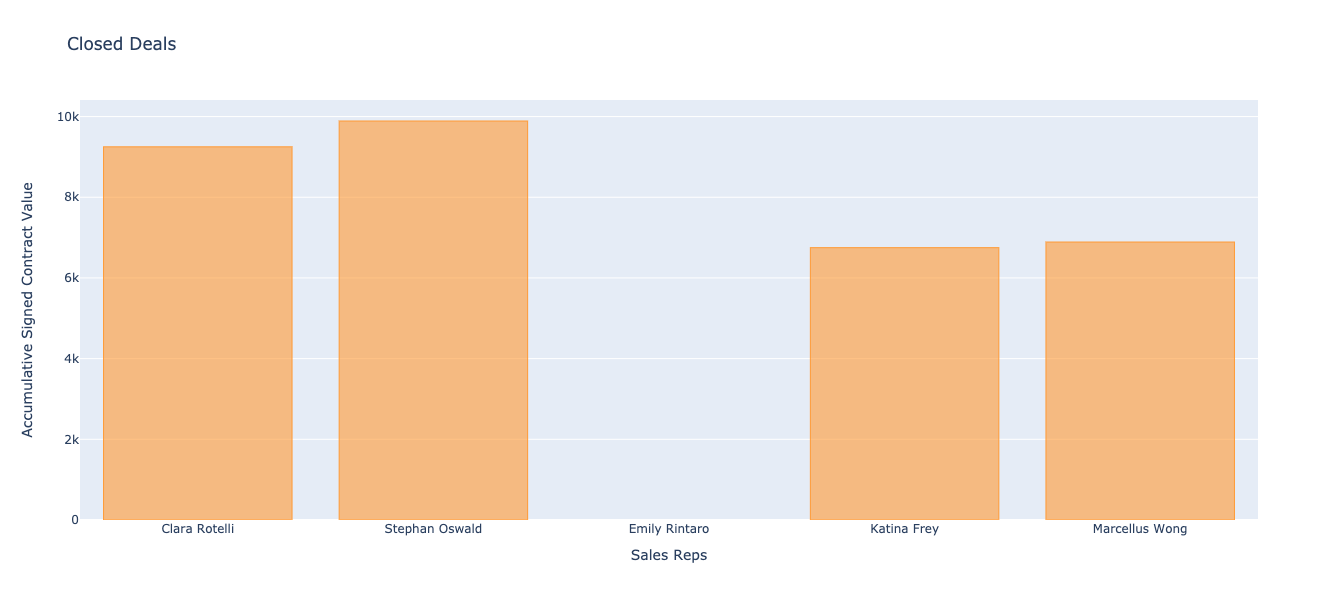

In [10]:
layout = cf.Layout(
    height = 600,
    width = 800,
    xaxis = dict(title = 'Sales Reps'),
    yaxis = dict(title = 'Accumulative Signed Contract Value'),
    title = 'Closed Deals'
)

sales_df[sales_df['Sales Stage']=='Closed-Won'][['Signed Contract Value', 'Rep']].set_index('Rep').iplot(kind='bar',layout=layout)

* Of our 8 sales reps, only 4 have closed deals.
* Stephen Oswald has closed nearly $10k in sales, closely followed by Clara Rotelli.

### 2. Deal valuations by stage & sales representative

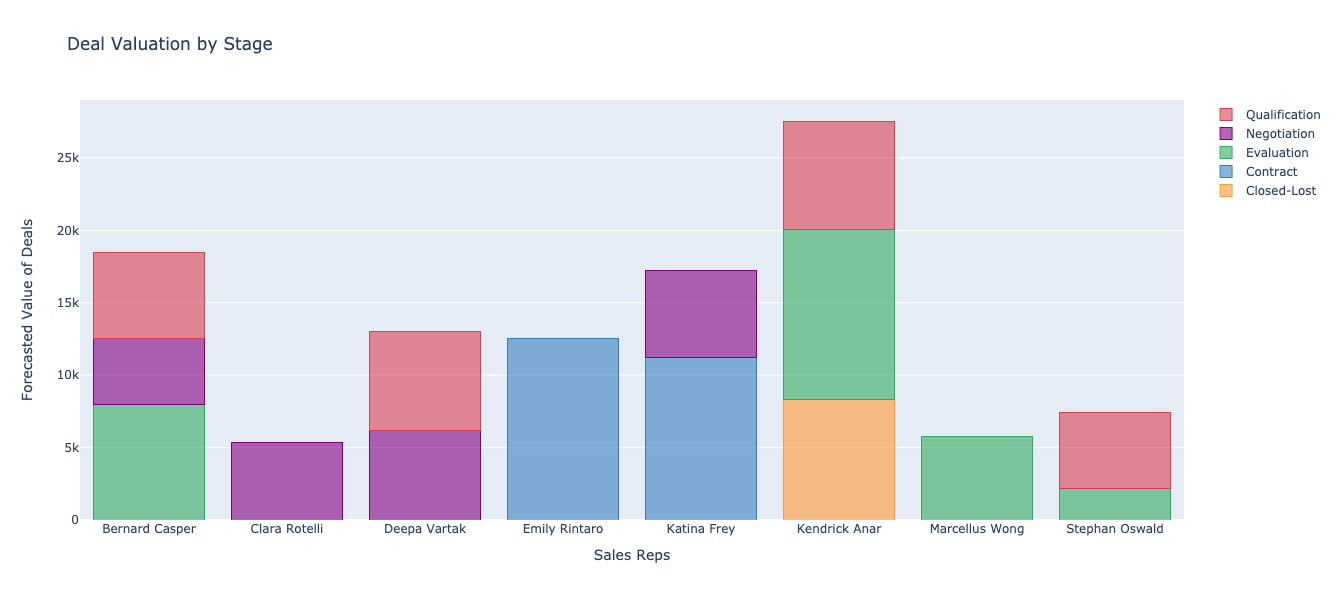

In [11]:
layout = cf.Layout(
    height = 600,
    width = 800,
    xaxis = dict(title = 'Sales Reps'),
    yaxis = dict(title = 'Forecasted Value of Deals'),
    title = 'Deal Valuation by Stage',
    barmode='stack'
)

pd.DataFrame(sales_df[sales_df['Sales Stage']!='Closed-Won'][['Name', 'Sales Stage', 'Forecast Value', 'Rep']].set_index('Sales Stage').groupby(
    ['Sales Stage', 'Rep'])['Forecast Value'].sum().unstack(level=0)).iplot(kind='bar', layout=layout)

* Stephen Oswald looks set to finish this quarter very strong - on top of his closed deals he has another $2k about to go to contract.
* Emily Rintaro may not have closed any deals yet, but the two deals she does have in the pipeline (already at contract stage) would put her well ahead of the pack for the quarter if she closes.
* Deepa Vartak will have to enter review if any of his ongoing deals fall through.

### 3. Forecasted deal valuations

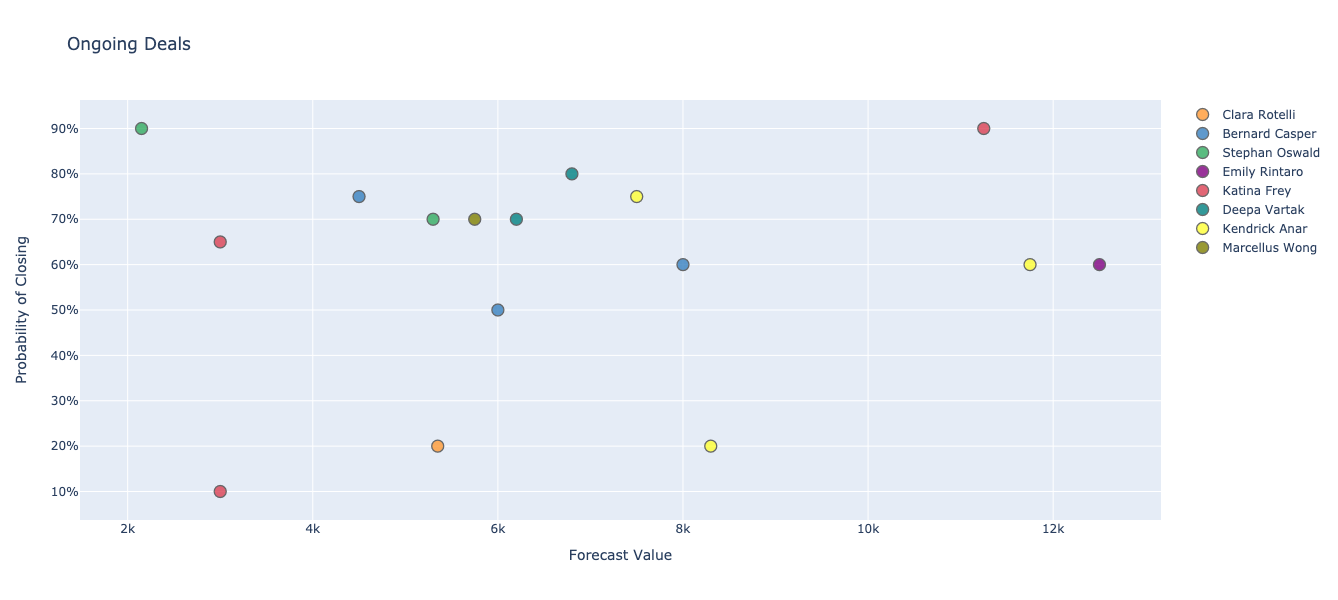

In [12]:
layout = cf.Layout(
    height = 600,
    width = 800,
    xaxis = dict(title = 'Forecast Value'),
    yaxis = dict(title = 'Probability of Closing',
                ticksuffix='%'),
    title = 'Ongoing Deals'
)

sales_df[sales_df['Sales Stage']!='Closed-Won'][['Probability','Forecast Value','Rep']].set_index('Forecast Value').reset_index().iplot(kind='scatter',mode='markers',x='Forecast Value',y='Probability',categories='Rep',layout=layout)

* Although Stephan Oswald's ongoing deals don't have the highest value, it's very likely they will all close.
* Here we can see that Deepa Vartak's ongoing deals are very likely to close. No need for a review at this stage.
* Kendrick Anar has not had a good quarter. But two of his ongoing deals are expected to be valued at a combined $19k, both highly likely to close.

### 4. Success rates of our sales reps

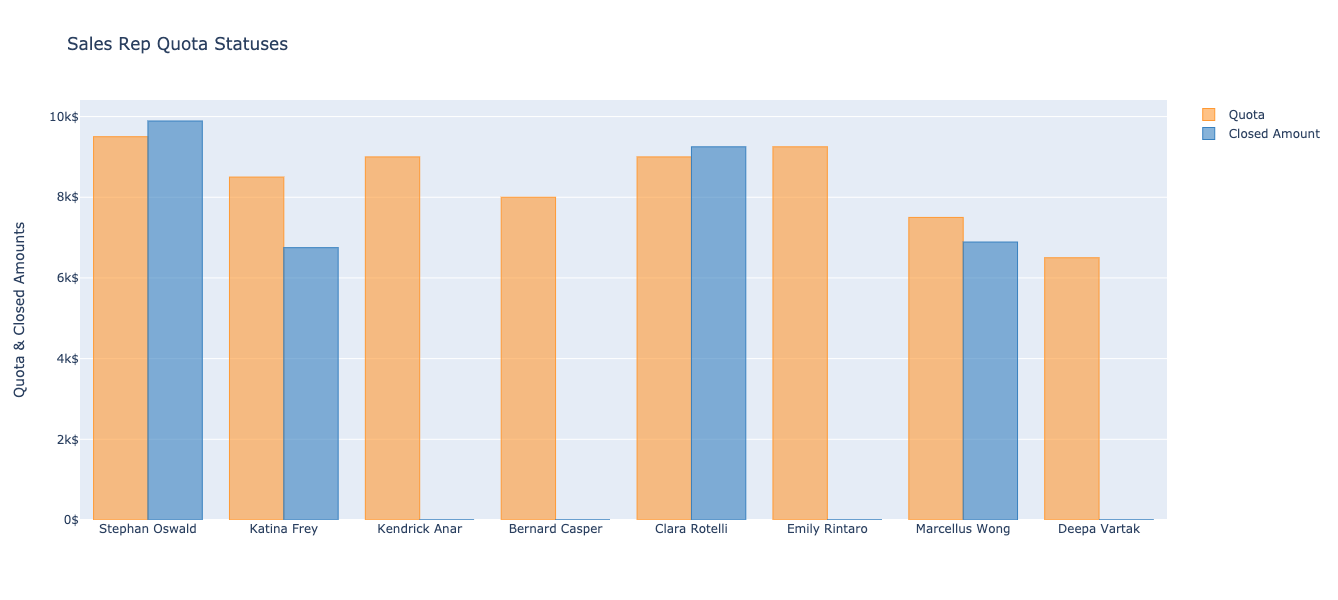

In [13]:
layout = cf.Layout(
    height = 600,
    width = 800,
    yaxis = dict(title = 'Quota & Closed Amounts',
                ticksuffix='$'),
    title = 'Sales Rep Quota Statuses'
)

fig = rep_df[['Name', 'Quota', 'Closed Amount']].set_index('Name').iplot(kind='bar', mode='group', layout=layout,asFigure=True)
fig['layout']['yaxis1'].update(title='Quota & Closed Amounts')
fig['layout']['yaxis1'].update(ticksuffix="$")
fig['data'][0].marker.update(opacity=1)
fig['data'][1].marker.update(opacity=1)

fig.iplot()

* Clara Rotelli and Stephan Oswald have hit their targets for Q1.
* Both Deepa Vartak and Kendrick Anar need to close their ongoing deals to avoid an end-of-quarter review.
* Katina Frey and Marcellus Wong are expected to hit their targets.